In [803]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.circuit import ParameterVector
from qiskit_algorithms.optimizers import COBYLA
import numpy as np

pqc_m = 1
num_address_qubits = 2
num_embedding_qubits = 1
num_qubits_total = num_address_qubits + num_embedding_qubits

### Layers

In [804]:
def encoding_layer(theta_params):
    encoding_layer = QuantumCircuit(num_qubits_total)

    # Apply controlled unitary operations to the embedding register
    # We use controlled Y-rotations for illustration; replace with appropriate unitaries
    for i in range(num_address_qubits):
        encoding_layer.cry(theta_params[i], control_qubit=i, target_qubit=num_address_qubits)

    return encoding_layer

def mixing_layer():
    mixing_layer = QuantumCircuit(num_qubits_total)

    # Apply the mixing layer with CNOT gates
    for i in range(num_address_qubits - 1):
        mixing_layer.cx(i, i + 1)

    return mixing_layer

def measurement_layer():
    measurement_layer = QuantumCircuit(num_qubits_total)
    cr_measurement = ClassicalRegister(num_address_qubits, name='meas')
    measurement_layer.add_register(cr_measurement)

    # Apply the measurement layer rotations to the address register qubits
    for i in range(num_address_qubits):
        measurement_layer.ry(np.pi / 2, i)

    # Measure only the address register qubits
    for i in range(num_address_qubits):
        measurement_layer.measure(i, cr_measurement[i])

    return measurement_layer

### Circuit

In [805]:
def create_circuit(theta_params):

    # Create the quantum circuit
    main_circuit = QuantumCircuit(QuantumRegister(num_address_qubits, name='address'), QuantumRegister(num_embedding_qubits, name='embedding'))
    cr_measurement = ClassicalRegister(num_address_qubits, name='measurement')
    main_circuit.add_register(cr_measurement)

    # Apply Hadamard gates to the address register qubits to create a superposition
    for i in range(num_address_qubits):
        main_circuit.h(i)

    # Parameterized quantum circuit (PQC)
    main_circuit.barrier()
    pqc = QuantumCircuit(num_qubits_total)
    for i in range(pqc_m):
        pqc.compose(encoding_layer(theta_params), inplace=True)
        pqc.compose(mixing_layer(), inplace=True)
    main_circuit.compose(pqc, inplace=True)

    # Apply the measurement layer
    main_circuit.barrier()
    main_circuit.compose(measurement_layer(), inplace=True)

    return main_circuit

### Simulation

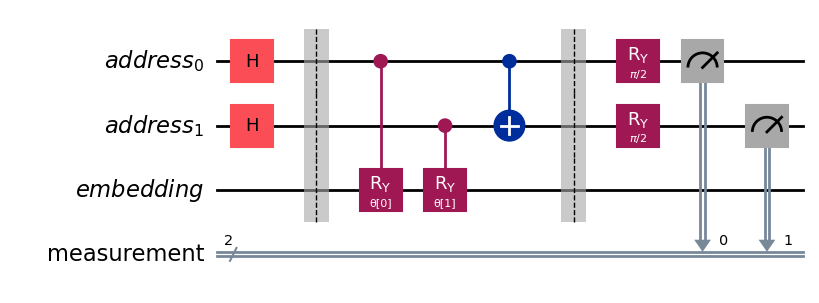

In [806]:
simulator = Aer.get_backend('aer_simulator')

theta = ParameterVector('θ', length=num_address_qubits)
circuit = create_circuit(theta)
circuit.draw(output='mpl')

In [807]:
# Transpile for simulation
transpiled_qc = transpile(circuit, simulator)

In [808]:
def estimate_inner_products_from_measurements(counts, num_address_qubits):
    # Initialize inner product estimates
    inner_products = np.zeros((2**num_address_qubits, 2**num_address_qubits))

    # Convert counts to probabilities
    total_counts = sum(counts.values())
    probabilities = {state: count / total_counts for state, count in counts.items()}

    # Iterate over all possible address register states
    for i in range(2**num_address_qubits):
        for j in range(2**num_address_qubits):
            # Convert to bit strings
            bitstring_i = format(i, f'0{num_address_qubits}b')
            bitstring_j = format(j, f'0{num_address_qubits}b')

            # For simplicity, we consider the probability of each state as the magnitude of its amplitude squared
            prob_i = probabilities.get(bitstring_i, 0)
            prob_j = probabilities.get(bitstring_j, 0)

            # Estimate inner products based on classical probabilities
            inner_products[i, j] = np.sqrt(prob_i * prob_j)

    return inner_products

# Use the estimate_inner_products_from_measurements function within the objective_function
def objective_function(theta_values, adjacency_matrix, gamma):
    global iteration

    # Assign parameters to the circuit and execute it
    bound_circuit = transpiled_qc.assign_parameters({theta: theta_values})
    job = simulator.run(bound_circuit, shots=8192)
    counts = job.result().get_counts()

    estimated_inner_products = estimate_inner_products_from_measurements(counts, num_address_qubits)

    # Calculate the loss based on the estimated inner products
    loss = 0
    max_loss =  np.sum(adjacency_matrix) - np.sum(np.diag(adjacency_matrix))

    for i in range(2**num_address_qubits):
        for j in range(2**num_address_qubits):
            if i != j:  # Exclude self-loops
                A_ij = adjacency_matrix[i, j]
                inner_product = estimated_inner_products[i, j]
                # Adjust the loss calculation for the deviation from the theoretical maximum
                loss += A_ij * (1 - inner_product) - gamma * (1 - A_ij) * inner_product

    # Scale and shift the loss from [-1, 1]
    normalized_loss = loss / max_loss * 2 - 1

    print('Iteration: {:2d} | Objective: {:0.7f}'.format(iteration, normalized_loss))

    iteration += 1
    return normalized_loss

In [809]:
adjacency_matrix = np.array([[0, 1, 1, 0], [1, 0, 1, 0], [1, 1, 0, 0], [1, 0, 0, 0]])
gamma = 0.5
iteration = 0

# Set up the optimizer
optimizer = COBYLA(maxiter=250)

theta_initial = np.full(num_address_qubits, np.pi)
opt_result = optimizer.minimize(lambda theta_values: -objective_function(theta_values, adjacency_matrix, gamma), theta_initial)

# bound to 0 to 2pi
optimal_theta = np.mod(opt_result.x, 2 * np.pi)

Iteration:  0 | Objective: 0.3204962
Iteration:  1 | Objective: 0.3567305
Iteration:  2 | Objective: 0.3808101
Iteration:  3 | Objective: 0.5480402
Iteration:  4 | Objective: 0.7371090
Iteration:  5 | Objective: 0.6854972
Iteration:  6 | Objective: 0.8521582
Iteration:  7 | Objective: 0.7979268
Iteration:  8 | Objective: 0.9591892
Iteration:  9 | Objective: 0.9138620
Iteration: 10 | Objective: 0.9188913
Iteration: 11 | Objective: 0.9380727
Iteration: 12 | Objective: 0.9041713
Iteration: 13 | Objective: 0.9772546
Iteration: 14 | Objective: 0.9858870
Iteration: 15 | Objective: 0.9820077
Iteration: 16 | Objective: 0.9631685
Iteration: 17 | Objective: 0.9936869
Iteration: 18 | Objective: 0.9846621
Iteration: 19 | Objective: 0.9873762
Iteration: 20 | Objective: 0.9846621
Iteration: 21 | Objective: 0.9910725
Iteration: 22 | Objective: 0.9873762
Iteration: 23 | Objective: 0.9936869
Iteration: 24 | Objective: 0.9826347
Iteration: 25 | Objective: 0.9936869
Iteration: 26 | Objective: 0.9873049
I